# Imports

In [1]:
# imports

import os, sys
import numpy as np
import SimpleITK as sitk

from helpers_general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [3]:
# Data path

PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")

Train data folders: [range(50002, 50017), range(50019, 50020), 50049, range(50455, 50464)]
Training data: key = train folder, value = full path to (segm obj, nii file)



### Atlas

In [4]:
# Load atlas: atlas MRs (10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment)

atlas_range, ras_adj = range(50455, 50464), True
atlas_folders = [str(i) for i in atlas_range]
atlas_objs, atlas_mask_objs = zip(*[folder2objs(atlas_folder, train_data_dict, ras_adj) \
                               for atlas_folder in atlas_folders])

### Input

In [5]:
# Load input: set input MRs (Samir's, no RAS adj needed for mask)

input_range, ras_adj = range(50002, 50017), False
input_folders = [str(i) for i in input_range]
input_objs, input_mask_objs = zip(*[folder2objs(input_folder, train_data_dict, ras_adj) \
                               for input_folder in input_folders])

### Crop to Foreground

In [6]:
def lmap(fn, arr, unpack_input=False, unpack_output=False):
    output = [fn(*o) for o in arr] if unpack_input else [fn(o) for o in arr]
    return zip(*output) if unpack_output else output

In [7]:
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image, mask):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return (sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]), \
            sitk.RegionOfInterest(mask, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]))

In [8]:
cropped_atlas_objs, cropped_atlas_mask_objs = lmap(threshold_based_crop, zip(atlas_objs, atlas_mask_objs), unpack_input=True, unpack_output=True)
cropped_input_objs, cropped_input_mask_objs = lmap(threshold_based_crop, zip(input_objs, input_mask_objs), unpack_input=True, unpack_output=True)

In [9]:
idx = 0
print("Cropped Atlas", cropped_atlas_objs[idx].GetSize(), "Original", atlas_objs[idx].GetSize())
print("Cropped Input", cropped_input_objs[idx].GetSize(), "Original", input_objs[idx].GetSize())

Cropped Atlas (146, 422, 331) Original (160, 480, 512)
Cropped Input (165, 200, 206) Original (176, 256, 256)


### Resample to Standard Reference Domain

In [10]:
img_data = [(o.GetSize(), o.GetSpacing()) for o in cropped_atlas_objs + cropped_input_objs]

In [11]:
# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb

dimension = 3 # 3D MRs
pixel_id = 2 # 16-bit signed integer

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)

#img_data = [(o.GetSize(), o.GetSpacing()) for o in (cropped_atlas_obj, cropped_input_obj)]
for img_sz, img_spc in img_data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                  for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()


# Isotropic (1,1,1) pixels
reference_spacing = np.ones(dimension)
reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

# Set reference image attributes
reference_image = sitk.Image(reference_size, pixel_id)
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [12]:
def resample(img, mask, interpolator = sitk.sitkLinear, default_intensity_value = 0.0):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value), \
            sitk.Resample(mask, reference_image, centered_transform, sitk.sitkNearestNeighbor, default_intensity_value)

In [13]:
atlas_objs, atlas_mask_objs = lmap(resample, zip(cropped_atlas_objs, cropped_atlas_mask_objs), unpack_input=True, unpack_output=True)
input_objs, input_mask_objs = lmap(resample, zip(cropped_input_objs, cropped_input_mask_objs), unpack_input=True, unpack_output=True)

In [14]:
# atlas
atlas_arrs        = lmap(sitk2np, atlas_objs)
atlas_mask_arrs   = lmap(sitk2np, atlas_mask_objs)
atlas_bbox_coords = lmap(mask2bbox, atlas_mask_arrs)

# input
input_arrs        = lmap(sitk2np, input_objs)
input_mask_arrs   = lmap(sitk2np, input_mask_objs)
input_bbox_coords = lmap(mask2bbox, input_mask_arrs)

### ROI info

In [15]:
from pandas import DataFrame

In [16]:
def is_bbox(arr, imin, imax, jmin, jmax, kmin, kmax):
    return np.all(arr[imin:imax, jmin:jmax, kmin:kmax])

def get_info_df_row(folder, obj, mask_arr, bbox_coord):
    #print(bbox_coord)
    shape0, shape1, shape2             = obj.GetSize()
    imin, imax, jmin, jmax, kmin, kmax = bbox_coord
    roi_size0, roi_size1, roi_size2    = imax-imin, jmax-jmin, kmax-kmin
    is_bbox_bool                       = is_bbox(mask_arr, *bbox_coord)
    
    return {"folder": folder, \
            "shape0": shape0, "shape1": shape1, "shape2": shape2, \
            "roi_size0": roi_size0, "roi_size1": roi_size1, "roi_size2": roi_size2, \
            "is_bbox": is_bbox_bool,
            "imin": imin, "imax":imax, \
            "jmin":jmin, "jmax": jmax, \
            "kmin": kmin, "kmax": kmax}
    
def get_info_df(folders, objs, mask_arrs, bbox_coords):
    return DataFrame([get_info_df_row(folder, obj, mask_arr, bbox) \
                      for folder, obj, mask_arr, bbox in zip(folders, objs, mask_arrs, bbox_coords)])

In [17]:
atlas_info_df = get_info_df(atlas_range, atlas_objs, atlas_mask_arrs, atlas_bbox_coords)
atlas_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50455,175,232,226,34,28,19,False,71,105,124,152,65,84
1,50456,175,232,226,31,25,17,False,70,101,126,151,85,102
2,50457,175,232,226,30,26,16,False,74,104,127,153,86,102
3,50458,175,232,226,26,24,20,False,74,100,126,150,79,99
4,50459,175,232,226,34,25,18,False,73,107,121,146,75,93
5,50460,175,232,226,30,28,16,False,74,104,124,152,66,82
6,50461,175,232,226,29,23,17,False,75,104,122,145,76,93
7,50462,175,232,226,32,25,17,False,72,104,126,151,83,100
8,50463,175,232,226,32,26,19,False,69,101,122,148,70,89


In [18]:
input_info_df = get_info_df(input_range, input_objs, input_mask_arrs, input_bbox_coords)
input_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50002,175,232,226,39,29,22,False,74,113,130,159,101,123
1,50003,175,232,226,31,24,21,False,72,103,128,152,110,131
2,50004,175,232,226,37,29,27,False,68,105,125,154,95,122
3,50005,175,232,226,33,26,20,False,74,107,121,147,101,121
4,50006,175,232,226,31,26,21,False,72,103,121,147,95,116
5,50007,175,232,226,33,27,21,False,71,104,142,169,96,117
6,50008,175,232,226,31,24,19,False,75,106,137,161,101,120
7,50009,175,232,226,39,25,20,False,69,108,125,150,102,122
8,50010,175,232,226,26,22,18,False,79,105,121,143,104,122
9,50011,175,232,226,30,25,23,False,74,104,136,161,110,133


### Align

In [19]:
def atlas2pred(input_obj, atlas_obj, atlas_mask_obj):
    
    elastixImageFilter = sitk.ElastixImageFilter()

    # set parameter map
    param_folder = "ElastixParamFiles"
    param_files = ["affine.txt"]

    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    
    # input = fixed, atlas = moving
    elastixImageFilter.SetFixedImage(input_obj)
    elastixImageFilter.SetMovingImage(atlas_obj)
    elastixImageFilter.Execute()

    #pred_obj = elastixImageFilter.GetResultImage()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(atlas_mask_obj)

    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    # pred_mask_obj = transformixImageFilter.GetResultImage()
    return transformixImageFilter.GetResultImage()

# Align2 = Pred ROI

In [20]:
# seems like 10x50x50 is enough padding. Hacky!

def get_bbox_margin(objs, bbox_coords, pads=[10,80,80]):
    
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords
    
    imin_pad, jmin_pad, kmin_pad = [max(0, m-pad) for m,pad in zip((imin, jmin, kmin), pads)]
    imax_pad, jmax_pad, kmax_pad = [min(sz, m+pad) for m,pad,sz in zip((imax, jmax, kmax), pads, objs[0].GetSize())]
    
    #print(imax_pad)
    
    return      (*[o[imin_pad:imax_pad, jmin_pad:jmax_pad, kmin_pad:kmax_pad] for o in objs], \
                (imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad))

### Test case pred ROI

In [21]:
input_idx = 0
atlas_idx = 0

pred_mask_obj = atlas2pred(input_objs[input_idx], atlas_objs[atlas_idx], atlas_mask_objs[atlas_idx])

In [22]:
pred_bbox_coords = mask2bbox(sitk2np(pred_mask_obj))

In [23]:
cropped_atlas_obj, cropped_atlas_mask_obj, cropped_input_obj, cropped_input_mask_obj, offset_coords = \
    get_bbox_margin((
              atlas_objs[atlas_idx], \
              atlas_mask_objs[atlas_idx], \
              input_objs[input_idx], \
              input_mask_objs[input_idx]), \
    pred_bbox_coords)

In [24]:
cropped_atlas_bbox_coords = mask2bbox(sitk2np(cropped_atlas_mask_obj))
cropped_input_bbox_coords = mask2bbox(sitk2np(cropped_input_mask_obj))

In [25]:
print("Atlas"); print_bbox(*atlas_bbox_coords[atlas_idx]); print();
print("Atlas ROI Margin"); print_bbox(*cropped_atlas_bbox_coords)
print()
print("Offset")
print_bbox(*offset_coords)
print();

print("Prediction ROI => Atlas ROI margin")
print("Prediction ROI"); print_bbox(*pred_bbox_coords)
print("Atlas ROI margin size: ", cropped_atlas_obj.GetSize())

Atlas
Bbox coords: (71, 124, 65) to (105, 152, 84). Size: 34, 28, 19.
Bounding box coord: from location (124, 65) of slice 71 to location (152, 84) of slice 105.

Atlas ROI Margin
Bbox coords: (7, 77, 52) to (41, 105, 71). Size: 34, 28, 19.
Bounding box coord: from location (77, 52) of slice 7 to location (105, 71) of slice 41.

Offset
Bbox coords: (64, 47, 13) to (120, 232, 201). Size: 56, 185, 188.
Bounding box coord: from location (47, 13) of slice 64 to location (232, 201) of slice 120.

Prediction ROI => Atlas ROI margin
Prediction ROI
Bbox coords: (74, 127, 93) to (110, 159, 121). Size: 36, 32, 28.
Bounding box coord: from location (127, 93) of slice 74 to location (159, 121) of slice 110.
Atlas ROI margin size:  (56, 185, 188)


In [26]:
# Check undo crop
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

def get_full_coords(offset_coords, bbox_within):
    offset_pts  = get_offset(offset_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full_mask_arr(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr

In [27]:
full_atlas_bbox_coords = get_full_coords(offset_coords, cropped_atlas_bbox_coords)
full_input_bbox_coords = get_full_coords(offset_coords, cropped_input_bbox_coords)

In [28]:
print(full_atlas_bbox_coords)
print(atlas_bbox_coords[atlas_idx])

(71, 105, 124, 152, 65, 84)
(71, 105, 124, 152, 65, 84)


In [29]:
print("Full     ", full_input_bbox_coords)
print("Original ", input_bbox_coords[input_idx])
print("Crop     ", cropped_input_bbox_coords)
print("Offset   ", offset_coords)

Full      (74, 113, 130, 159, 101, 123)
Original  (74, 113, 130, 159, 101, 123)
Crop      (10, 49, 83, 112, 88, 110)
Offset    (64, 120, 47, 232, 13, 201)


In [30]:
print("Unaligned Dice: ", compute_dice_coefficient(input_mask_arrs[input_idx], atlas_mask_arrs[atlas_idx]))
print("Aligned1 Dice: ", compute_dice_coefficient(input_mask_arrs[input_idx], sitk2np(pred_mask_obj)))

Unaligned Dice:  0.0
Aligned1 Dice:  0.6781862460860489


In [31]:
cascade_area = np.full(sitk2np(cropped_input_obj).shape, True)
cascade_coords = pts2coords((*(0,0,0), *cropped_input_obj.GetSize()))
cascade_mask = cascade2full_mask_arr(input_mask_arrs[input_idx].shape, 
                                                    offset_coords,
                                                    cascade_area,
                                                    cascade_coords)

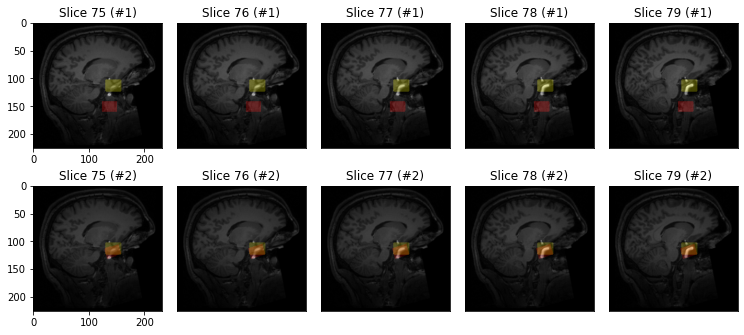

In [32]:
# viz
# Row 1 = input arr + input roi + atlas roi
# Row 2 = input arr + input roi + pred roi

viz_axis(np_arr = input_arrs[input_idx], \
        bin_mask_arr   = input_mask_arrs[input_idx], color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = atlas_mask_arrs[atlas_idx], color2 = "red", alpha2=0.3, \
        slices=lrange(75,80), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = input_arrs[input_idx], \
        bin_mask_arr_b   = input_mask_arrs[input_idx], color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = sitk2np(pred_mask_obj),     color2_b = "red", alpha2_b=0.3, \
        slices_b = lrange(75,80), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

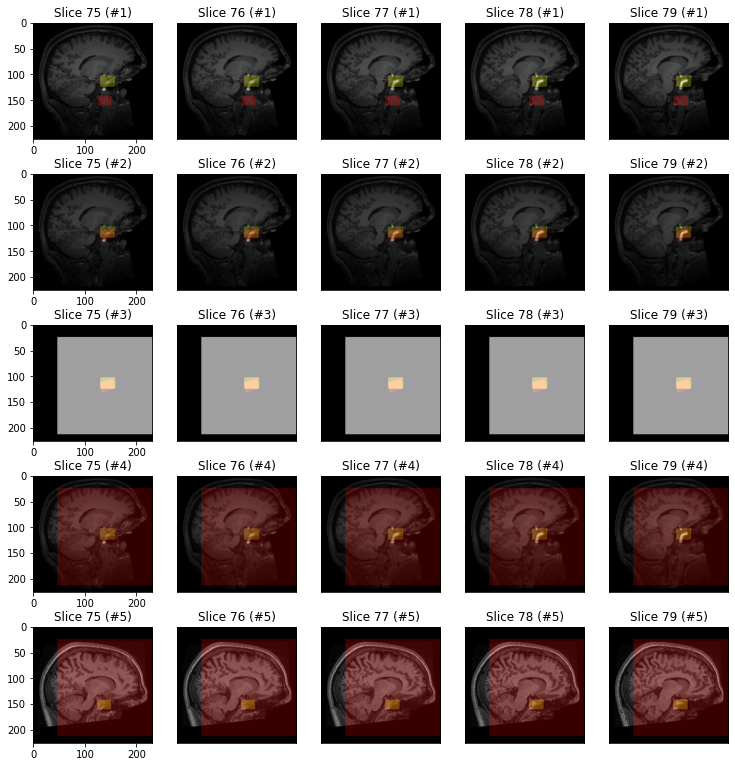

In [33]:
# viz
# Row 1 = input arr + input roi + atlas roi
# Row 2 = input arr + input roi + pred roi

viz_axis(np_arr = input_arrs[input_idx], \
        bin_mask_arr   = input_mask_arrs[input_idx], color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = atlas_mask_arrs[atlas_idx], color2 = "red", alpha2=0.3, \
        slices=lrange(75,80), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = input_arrs[input_idx], \
        bin_mask_arr_b   = input_mask_arrs[input_idx], color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = sitk2np(pred_mask_obj),     color2_b = "red", alpha2_b=0.3, \
        slices_b = lrange(75,80), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        np_arr_c = cascade_mask.astype(np.uint), \
        bin_mask_arr_c   = input_mask_arrs[input_idx], color1_c = "yellow", alpha1_c=0.3, \
        bin_mask_arr2_c  = sitk2np(pred_mask_obj),     color2_c = "red", alpha2_c=0.3, \
        slices_c = lrange(75,80), fixed_axis_c=0, \
        axis_fn_c = np.rot90, \
         
        np_arr_d = input_arrs[input_idx], \
        bin_mask_arr_d   = input_mask_arrs[input_idx], color1_d = "yellow", alpha1_d=0.3, \
        bin_mask_arr2_d  = cascade_mask,     color2_d = "red", alpha2_d=0.3, \
        slices_d = lrange(75,80), fixed_axis_d=0, \
        axis_fn_d = np.rot90, \
         
        np_arr_e = atlas_arrs[atlas_idx], \
        bin_mask_arr_e   = atlas_mask_arrs[atlas_idx], color1_e = "yellow", alpha1_e=0.3, \
        bin_mask_arr2_e  = cascade_mask,     color2_e = "red", alpha2_e=0.3, \
        slices_e = lrange(75,80), fixed_axis_e=0, \
        axis_fn_e = np.rot90, \
         
        grid = [5, 5], hspace=0.3, fig_mult=2)

# Cascade align

In [34]:
pred_mask_obj2 = atlas2pred(cropped_input_obj, cropped_atlas_obj, cropped_atlas_mask_obj)

In [35]:
print(pred_mask_obj2.GetSize())

(56, 185, 188)


In [36]:
pred_mask2_arr              = sitk2np(pred_mask_obj2)
pred_mask2_bbox_coords      = mask2bbox(pred_mask2_arr)
pred_mask2_full_bbox_coords = get_full_coords(offset_coords, pred_mask2_bbox_coords)
pred_mask2_full_arr         = cascade2full_mask_arr(input_mask_arrs[input_idx].shape, 
                                                    pred_mask2_full_bbox_coords,
                                                    pred_mask2_arr,
                                                    pred_mask2_bbox_coords)

In [37]:
print_bbox(*pred_mask2_full_bbox_coords)
print_bbox(*input_bbox_coords[input_idx])

Bbox coords: (74, 122, 94) to (107, 150, 120). Size: 33, 28, 26.
Bounding box coord: from location (122, 94) of slice 74 to location (150, 120) of slice 107.
Bbox coords: (74, 130, 101) to (113, 159, 123). Size: 39, 29, 22.
Bounding box coord: from location (130, 101) of slice 74 to location (159, 123) of slice 113.


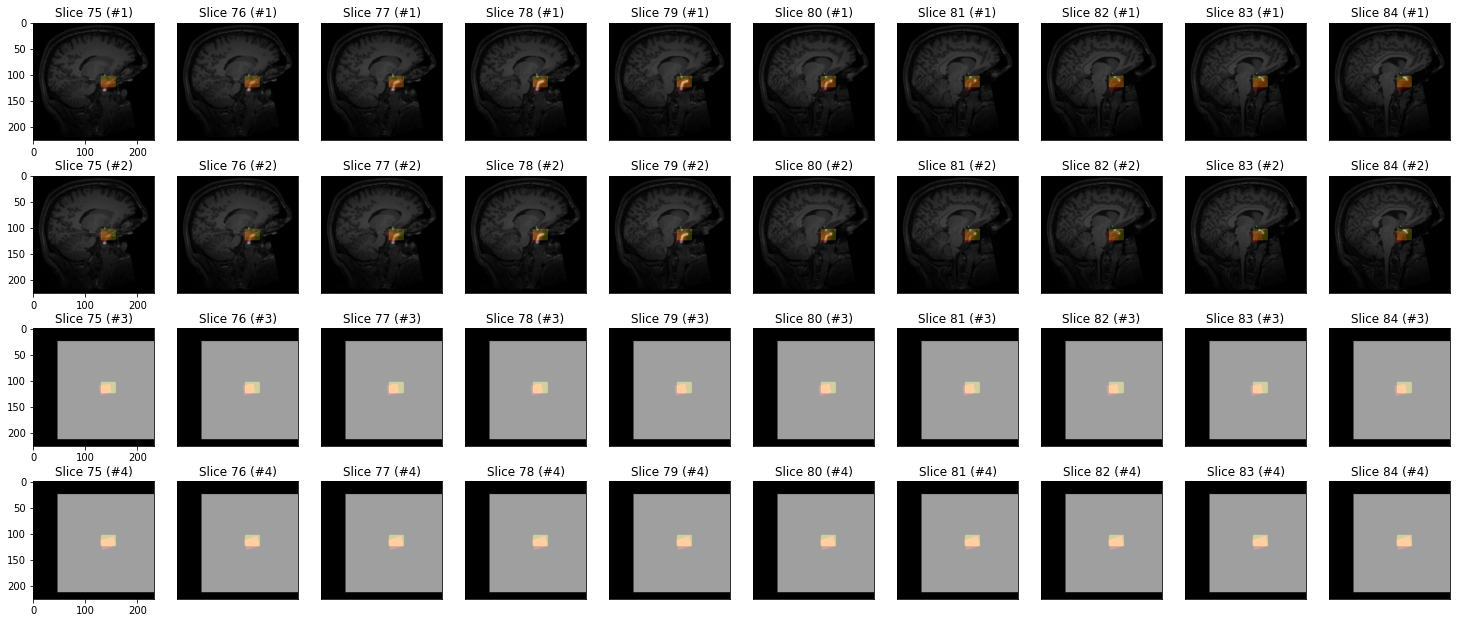

In [38]:
# viz
# Row 1 = input arr + input roi + atlas roi
# Row 2 = input arr + input roi + pred roi

viz_axis(np_arr = input_arrs[input_idx], \
        bin_mask_arr   = input_mask_arrs[input_idx], color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = sitk2np(pred_mask_obj),     color2 = "red", alpha2=0.3, \
        slices=lrange(75,85), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = input_arrs[input_idx], \
        bin_mask_arr_b   = input_mask_arrs[input_idx], color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = pred_mask2_full_arr,        color2_b = "red", alpha2_b=0.3, \
        slices_b = lrange(75,85), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        np_arr_c = cascade_mask.astype(np.uint), \
        bin_mask_arr_c   = input_mask_arrs[input_idx], color1_c = "yellow", alpha1_c=0.3, \
        bin_mask_arr2_c  = pred_mask2_full_arr,     color2_c = "red", alpha2_c=0.3, \
        slices_c = lrange(75,85), fixed_axis_c=0, \
        axis_fn_c = np.rot90, \
         
        np_arr_d = cascade_mask.astype(np.uint), \
        bin_mask_arr_d   = input_mask_arrs[input_idx], color1_d = "yellow", alpha1_d=0.3, \
        bin_mask_arr2_d  = sitk2np(pred_mask_obj),     color2_d = "red", alpha2_d=0.3, \
        slices_d = lrange(75,85), fixed_axis_d=0, \
        axis_fn_d = np.rot90, \
         
        grid = [4, 10], hspace=0.3, fig_mult=2)

In [39]:
cascade_dice      = compute_dice_coefficient(sitk2np(cropped_input_mask_obj), pred_mask2_arr)
cascade_dice_full = compute_dice_coefficient(input_mask_arrs[input_idx], pred_mask2_full_arr)

In [40]:
print(cascade_dice)
print(cascade_dice_full)

0.4551175711614925
0.4551175711614925


In [41]:
mask_gt = (sitk2np(cropped_input_mask_obj)).astype(bool)
mask_pred = pred_mask2_arr.astype(bool)
volume_intersect = (mask_gt & mask_pred).sum()

In [42]:
mask_gt = input_mask_arrs[input_idx].astype(bool)
mask_pred = pred_mask2_full_arr.astype(bool)
volume_intersect_full = (mask_gt & mask_pred).sum()

In [43]:
print(volume_intersect)
print(volume_intersect_full)

8642
8642


In [46]:
print("Unaligned Dice: ", compute_dice_coefficient(input_mask_arrs[input_idx], atlas_mask_arrs[atlas_idx]))
print("Aligned1 Dice: ",  compute_dice_coefficient(input_mask_arrs[input_idx], sitk2np(pred_mask_obj)))
print("Aligned2 Dice: ",  compute_dice_coefficient(input_mask_arrs[input_idx], pred_mask2_full_arr))

Unaligned Dice:  0.0
Aligned1 Dice:  0.6781862460860489
Aligned2 Dice:  0.4551175711614925


In [ ]:
print("Aligned2 Dice: ", compute_dice_coefficient(sitk2np(cropped_input_mask_obj).astype(bool), sitk2np(pred_mask_obj2).astype(bool)));
print("Aligned1 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(pred_mask_obj).astype(bool)));
print("Unaligned Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(atlas_mask_objs[0]).astype(bool)))

In [ ]:
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

def get_full_coords(cropped_bbox_coords, bbox_within):
    offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full_mask_arr(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr

In [ ]:
pred_mask_arr2 = sitk2np(pred_mask_obj2)
bbox_within = mask2bbox(pred_mask_arr2)
full_coords = get_full_coords(cropped_bbox_coords, bbox_within)
full_mask_arr = cascade2full_mask_arr(input_mask_arrs[0].shape, full_coords, pred_mask_arr2, bbox_within)

In [ ]:
print("Full Aligned2 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), full_mask_arr.astype(bool)));
print("Aligned2 Dice: ", compute_dice_coefficient(sitk2np(cropped_input_mask_obj).astype(bool), sitk2np(pred_mask_obj2).astype(bool)));
print("Aligned1 Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(pred_mask_obj).astype(bool)));
print("Unaligned Dice: ", compute_dice_coefficient(sitk2np(input_mask_objs[0]).astype(bool), sitk2np(atlas_mask_objs[0]).astype(bool)))

In [ ]:
# viz
# Row 1 = full: pred1, input1
# Row 2 = cropped: pred2, input2
viz_axis(np_arr = sitk2np(input_objs[0]), \
        bin_mask_arr   = input_mask_arrs[0], color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = sitk2np(pred_mask_obj), color2 = "red", alpha2=0.3, \
        slices=lrange(75,80), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = sitk2np(cropped_input_obj), \
        bin_mask_arr_b   = sitk2np(cropped_input_mask_obj), color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = sitk2np(pred_mask_obj2), color2_b = "red", alpha2_b=0.3, \
        slices_b = lrange(35,41), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [ ]:
def cascaded_align_row(input_obj, input_mask_obj, atlas_objs=atlas_objs, atlas_mask_obj=atlas_mask_objs, mult_factor=2):
    
    dice_scores = {}
    n_votes = len(atlas_objs)
    print(f"N={n_votes} atlases in the vote.")
    
    input_mask_arr = sitk2np(input_mask_obj)
    
    for i in range(n_votes):
        print(f"Getting pred for atlas {i}:")
        
        pred_mask_obj1 = atlas2pred(input_obj, atlas_objs[i], atlas_mask_objs[i])
        pred_mask_arr1 = sitk2np(pred_mask_obj1)
        bbox = mask2bbox(pred_mask_arr1)
        
        print("aligned1")

        # crop given 1st ROI estimation
        cropped_atlas_obj, cropped_atlas_mask_obj, cropped_input_obj, cropped_input_mask_obj, cropped_bbox_coords = \
            crop2roi((atlas_objs[i], atlas_mask_objs[i], input_obj, input_mask_obj), bbox, mult_factor)
        
        # re-align
        pred_mask_obj2 = atlas2pred(cropped_input_obj, cropped_atlas_obj, cropped_atlas_mask_obj)
        pred_mask_arr2 = sitk2np(pred_mask_obj2)
        
        print("aligned2")
        
        # compute dice
        dice1 = compute_dice_coefficient(input_mask_arr, pred_mask_arr1)
        dice2 = compute_dice_coefficient(sitk2np(cropped_input_mask_obj), pred_mask_arr2)
        
        # save dice
        dice_scores[f"dice{i}"]     = dice1
        dice_scores[f"csc_dice{i}"] = dice2
    
        # add atlas vote
        
        # convert pred_mask_arr2 to full (for voting, need standard size)
        bbox_within = mask2bbox(pred_mask_arr2)
        full_coords = get_full_coords(cropped_bbox_coords, bbox_within)
        full_mask_arr2 = cascade2full_mask_arr(input_mask_arr.shape, full_coords, pred_mask_arr2, bbox_within)
            
        if i == 0:
            vote_pred_mask_arr1 = pred_mask_arr1.astype(np.uint8)
            vote_pred_mask_arr2 = full_mask_arr2.astype(np.uint8)
            
        else: 
            vote_pred_mask_arr1 += pred_mask_arr1.astype(np.uint8)
            vote_pred_mask_arr2 += full_mask_arr2.astype(np.uint8)

    # get avg dice score
    dice_scores[f"dice_avg"] = np.mean([v for k,v in dice_scores.items() if not k.startswith("csc")])
    dice_scores[f"csc_dice_avg"] = np.mean([v for k,v in dice_scores.items() if k.startswith("csc")])
    
    # get vote
    print(f"Getting vote dice")
    vote_pred_mask_arr1 = (vote_pred_mask_arr1 >= n_votes/2).astype(bool)
    vote_pred_mask_arr2 = (vote_pred_mask_arr2 >= n_votes/2).astype(bool)
    
    dice_scores[f"dice_vote_all"]     = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr1)
    dice_scores[f"csc_dice_vote_all"] = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr2)
    
    #print(dice_scores)
    return dice_scores

In [ ]:
return la ba sa ca da fa ta ye

In [ ]:
test_row = cascaded_align_row(input_objs[0], input_mask_objs[0], atlas_objs[:2], atlas_mask_objs[:2], mult_factor=2)

In [ ]:
test_df = DataFrame([test_row])
test_df

In [ ]:
cols = test_df.columns.tolist()
csc_cols = [c for c in cols if c.startswith("csc")]
non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
test_df[csc_cols]

In [ ]:
test_df[non_csc_cols]

In [ ]:
input_rows = [None] * len(input_range)
for i in range(len(input_range)):
    print(f"Row {i}: {input_range[i]}")
    
    try:
        input_rows[i] = cascaded_align_row(input_objs[i], input_mask_objs[i], atlas_objs, atlas_mask_objs, mult_factor=2)
    
        df = DataFrame([input_rows[i]])
        cols = df.columns.tolist()
        csc_cols = [c for c in cols if c.startswith("csc")]
        non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

        display(df[non_csc_cols])
        display(df[csc_cols])
        
    except Exception as e:
        pass
        #print("Message:\n ", e.message, "\n", "Args:\n ", e.args)
        

In [ ]:
for i,test_row in enumerate(input_rows):
    print(f"Row {i}: {input_range[i]}")
    
    df = DataFrame([test_row])
    cols = df.columns.tolist()
    csc_cols = [c for c in cols if c.startswith("csc")]
    non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]
    
    display(df[non_csc_cols])
    display(df[csc_cols])

In [ ]:
input_df = DataFrame(cascaded_align_row(input_obj, input_mask_obj, atlas_objs, atlas_mask_objs, mult_factor=2)
                     for input_obj, input_mask_obj in zip(input_objs, input_mask_objs))

In [ ]:
cols = input_df.columns.tolist()
csc_cols = [c for c in cols if c.startswith("csc")]
non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
input_df[csc_cols]

In [ ]:
input_df[non_csc_cols]

In [ ]:
def reorder_cols(df):
    cols = df.columns.tolist()
    csc = [c for c in cols if c.startswith("csc") and c]
    noncsc  = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
# pred_objs, pred_mask_objs = lmap(atlas2pred, zip(resampled_atlas_objs, resampled_atlas_mask_objs, resampled_input_objs), unpack_input=True)

In [ ]:
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

#### H_0 Null

Align Atlas ROI + pad to full Input


In [ ]:
# imagine I have bbox within aligned loc (5,10,20) to (10,35,76)
bbox_within = pts2coords((5,10,20,10,35,76))
print_bbox(*bbox_within)

In [ ]:
# test
offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
coords_pts  = coords2pts(bbox_within)
full_coords = pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

print_bbox(*full_coords);


In [ ]:
def get_full_coords(cropped_bbox_coords, bbox_within):
    offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr


In [ ]:
# Viz

# Row 1. Full atlas w/ full coords
# Row 2. Cropped atlas w/ crop coords

viz_axis(np_arr = sitk2np(resampled_arr_objs[0]), \
        bin_mask_arr  = cascade_input_mask_arr, color1 = "yellow", alpha1=0.7, \
        bin_mask_arr2  = cascade_pred_mask_arr, color2 = "red", alpha2=0.7, \
        slices=cascade_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = cascade_pred_arr, \
        bin_mask_arr_b  = cascade_pred_mask_arr, color1_b = "yellow", alpha1_b=0.3,
        slices_b = cascade_pred_slice_range,
         
        np_arr_c = cascade_atlas_arr, \
        bin_mask_arr_c  = cascade_atlas_mask_arr, color1_c = "yellow", alpha1_c=0.3,
        slices_c = cascade_atlas_slice_range,
         
        grid = [3, 8], hspace=0.3, fig_mult=2)